In [1]:
#################################################################### Loading packages ####################################################################
import sys as sys
import os
import numpy as np
import scipy.stats as scs
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm
import pickle
import math 
import re
from Censored_copula import *
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import euclidean_distances 
import pandas as pd
from scipy.optimize import dual_annealing
from joblib import Parallel, delayed
import psutil


#################################################################### Loading GNM ####################################################################
model_version = 0 
target_distribution = "gamma_hurdle"
base_nn = "HConvLSTM_tdscale"
sys.path.append('../')

import pickle
import torch

path_ = f"Checkpoints/uk_rain_DGLM_{base_nn}_{target_distribution}/lightning_logs/version_{model_version}/"
#ckpt_path = glms.NeuralDGLM.get_ckpt_path(os.path.join(path_,"checkpoints"))
ckpt_path = 'Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_0/checkpoints/epoch=3-step=9008-val_loss_loss=-0.552-val_metric_mse_rain=26.500.ckpt'
print([path_,ckpt_path])
'''
scaler_features, scaler_target = glms.NeuralDGLM.load_scalers(path_)
model = glms.NeuralDGLM.load_from_checkpoint(ckpt_path, save_hparams=False, scaler_features=scaler_features, scaler_target=scaler_target)
model.freeze()
model.eval()
'''
GNM_output = pickle.load( open(os.path.join(path_,"test_output_1979_1993-03.pkl"),"rb") )

#################################################################### Problematic locations? ###############################################################

location_keys = list(GNM_output.keys())                 # '([0, 16], [44, 60])', ...
output_keys = list(GNM_output[location_keys[0]].keys()) # 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'date', 5'pred_p', 6'mask', 7'idx_loc_in_region'


# May have to remove a location that doesn't have the correct number of days:
#location_keys.remove(location_keys[344]) #to remove for gamma_20_20
#location_keys.remove(location_keys[171]) # to remove for gamma_20_20_unseen
location_keys.remove(location_keys[336]) # to remove for gamma_20_20_train
#################################################################### Utility functions ####################################################################
def give_lat_lon(location_key):
    return [ int(re.findall(r'\d+',string)[0]) for string in location_key.split(',')]

def is_loc_land(location,row,column):
    return GNM_output[location]['mask'][0][row][column]

#location_keys.remove('lat_50.95_49.35_lon_-4.55_-2.95') # 'lat_50.95_49.35_lon_-4.55_-2.95' has no data after week indexed 255, so I did not consider it.
day_dates = [pd.to_datetime(i).date() for i in GNM_output[location_keys[0]]['date']]
output_keys.remove('idx_loc_in_region') # not usefull
output_keys.remove('date') # no more usefull

#################################################################### Making list for land locations ####################################################################
#GNM_landonly[location][param][day]
# 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'pred_p', 5'location'

GNM_landonly = [] 
land_counter = -1
for location in tqdm(location_keys):
    for col in range(4):
        for row in range(4):
            if not is_loc_land(location,row,col):#check if land
               continue  
            land_counter+=1
            GNM_landonly.append([[],[],[],[],[]]) # parameters except location
            temp_lat_lon = give_lat_lon(location)
            GNM_landonly[land_counter].append([temp_lat_lon[1]-8+row,(temp_lat_lon[2])+6+col]) #location
            for param_idx,param in enumerate(output_keys[:-1]):
                for day in range(len(GNM_output[location_keys[0]]['pred_mu'])):
                    qqq = [location,param,day,row,col]
                    GNM_landonly[land_counter][param_idx].append(GNM_output[location][param][day][row,col])

dist_mat = distance_matrix(np.matrix([[GNM_landonly[loc][5][0],GNM_landonly[loc][5][1]] for loc in range(len(GNM_landonly))]),np.matrix([[GNM_landonly[loc][5][0],GNM_landonly[loc][5][1]] for loc in range(len(GNM_landonly))]))

#################################################################### Elevation data ####################################################################
import netCDF4 as nc
fn = 'topo_0.1_degree.nc'
ds = nc.Dataset(fn)
h = ds['Band1'][:]
h = np.flip(np.matrix(h),axis=0)
topo_dist = euclidean_distances(np.array([h[loc[5][0],loc[5][1]+2] for loc in GNM_landonly]).reshape(-1,1))

['Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_0/', 'Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_0/checkpoints/epoch=3-step=9008-val_loss_loss=-0.552-val_metric_mse_rain=26.500.ckpt']


100%|██████████| 344/344 [01:03<00:00,  5.41it/s]


### Plotting to make sure everything is in order

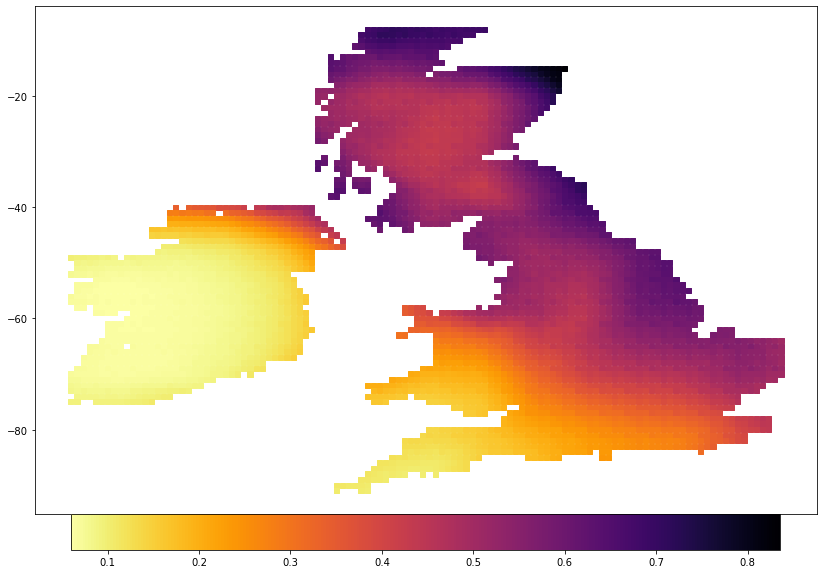

In [44]:
#check rain is correct
for day in range(1):
    fig = plt.gcf() 
    fig.set_size_inches(14,10)

    plt.scatter([GNM_landonly[loc][5][1] for loc in range(4087)],[-GNM_landonly[loc][5][0] for loc in range(4087)],c=[GNM_landonly[loc][4][day] for loc in range(4087)],cmap='inferno_r',s=27,marker='s')
    plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
    plt.show()

## Forecasts

Has to be done with the train set, so remember to change the JGNM experiment.

### Converting observations to us + Sample covariance matrix?

In [2]:
#GNM_landonly[location][param][day]
# 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'pred_p', 5'location'
def get_cdf_gnm(places):
    out=[]
    for idx,place in enumerate(places):
        out.append([])    
        for day in range(len(place[3])):
            scaling = np.random.uniform(size=1)
            obs = place[3][day]
            p = place[4][day]

            if obs==0: # dry day -> 1-p
                out[idx].append(scaling*(1-p))
            else: # rainy day -> (1-p)+p.cdf_x
                mu,disp = place[0][day],place[1][day]
                out[idx].append( (1-p)+(p*scs.gamma(scale=disp*mu,a=1/disp).cdf(obs)) )
    return out

obs_u_all_ = []
for locs in tqdm(np.array_split(np.array(range(len(GNM_landonly))),67)):
    
    size = math.ceil(len(locs)/psutil.cpu_count())
    locs_chuncks = [[GNM_landonly[i] for i in locs][x:x+size] for x in range(0,len(locs), size)]
    
    obs_u_all_.append( Parallel(n_jobs=psutil.cpu_count())(delayed(get_cdf_gnm)(chunck) for chunck in locs_chuncks) )



100%|██████████| 67/67 [20:51<00:00, 18.67s/it]


In [106]:
# Save
with open('obs_u_all_.txt','wb') as f:
    pickle.dump(obs_u_all_,f)
'''
#Load 
with open('obs_u_all_.txt','rb') as f:
    obs_u_all_ = pickle.load(f)'''

"\n#Load \nwith open('obs_u_all_.txt','rb') as f:\n    obs_u_all_ = pickle.load(f)"

C:\Users\u1819911\AppData\Local\Temp\ipykernel_16044\2457680219.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  obs_u_all = np.concatenate(np.array(obs_u_all_).flatten()).flatten()
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


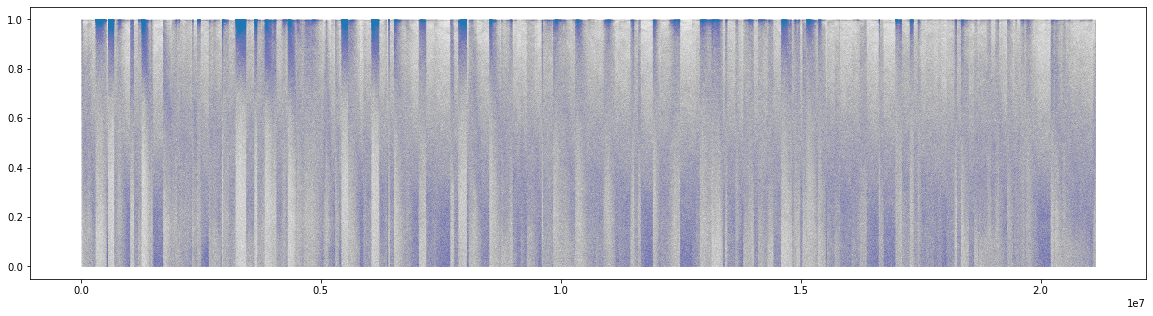

In [134]:
plt.figure(figsize=(20,5))
obs_u_all = np.concatenate(np.array(obs_u_all_).flatten()).flatten()
obs_u_all = np.array(obs_u_all).astype(float)
plt.scatter( range(len(obs_u_all)),obs_u_all,s=0.000005)
plt.show()

### Difference between adding and multiplying kernels

In [104]:
from sklearn.gaussian_process.kernels import Matern
M_topo,M_dist = Matern(length_scale=9000,nu=6.5).__call__(topo_dist[:2000,:2000]) , Matern(length_scale=9000,nu=6.5).__call__(dist_mat[:2000,:2000]) 
test_multiply =np.multiply( M_topo,M_dist)
test_add =np.add( M_topo,M_dist )/2

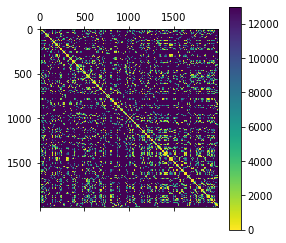

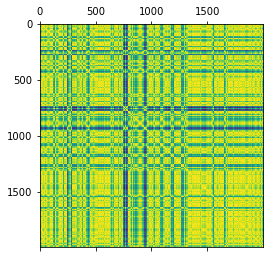

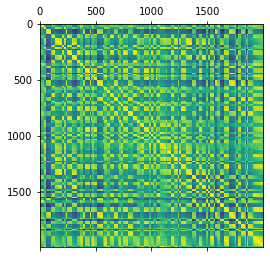

In [107]:
plt.matshow(np.multiply(topo_dist[:2000,:2000],dist_mat[:2000,:2000]),cmap='viridis_r',vmax=13000)
plt.colorbar()
plt.matshow(topo_dist[:2000,:2000],cmap='viridis_r')
plt.matshow(dist_mat[:2000,:2000],cmap='viridis_r')

### Finding a local set of points

In [99]:
# finds the indexes (gives a nested array).Add [0] to get it as an array.
np.where([math.dist(GNM_landonly[k][5],GNM_landonly[10][5])<2 for k in range(len(GNM_landonly))])[0]
# gives the loctions themselves
[GNM_landonly[i][5] for i in np.where([math.dist(GNM_landonly[k][5],GNM_landonly[10][5])<2 for k in range(len(GNM_landonly))])[0]]

[[41, 42],
 [42, 42],
 [43, 42],
 [41, 43],
 [42, 43],
 [43, 43],
 [41, 44],
 [42, 44],
 [43, 44]]

69


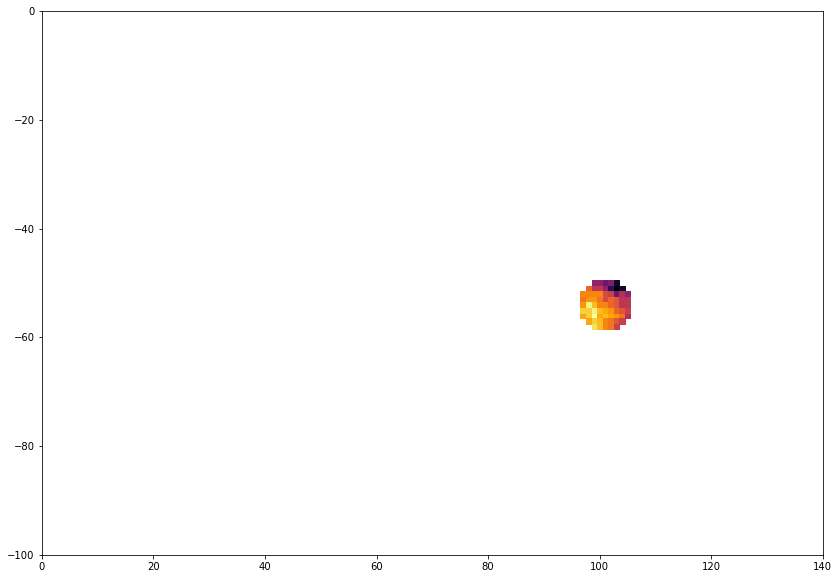

In [86]:
# spacially subsampling
fig = plt.gcf() 
fig.set_size_inches(14,10)
#random_center = np.random.choice(range(len(GNM_landonly))) 
locs = np.where([math.dist(GNM_landonly[k][5],GNM_landonly[random_center ][5])<5 for k in range(len(GNM_landonly))])[0]
print(len(locs))

plt.scatter([GNM_landonly[loc][5][1] for loc in locs],
[-GNM_landonly[loc][5][0] for loc in locs],
c=[GNM_landonly[loc][3][day] for loc in locs],
cmap='inferno_r',s=27,marker='s')

plt.xlim(0,140)
plt.ylim(-100,0)
plt.show()

### Estimation with Scoring Rules

In [3]:
# Transform observations into Us with respect to their marginals. (1-p) + p*CDF(x), 1m30

obs_norm_all = []
for day in tqdm(range(len(GNM_landonly[0][1]))):
    
    # Transform observations into Us with respect to their marginals. (1-p) + p*CDF(x)
    us = np.array(1-np.array([GNM_landonly[l][4][day] for l in range(4087)]) + np.multiply( # 1-p +
                        [GNM_landonly[l][4][day] for l in range(4087)],                     # p *
                        scs.gamma(                                                          # CDF(x)
                            scale=np.multiply([GNM_landonly[l][0][day] for l in range(4087)],[GNM_landonly[l][1][day] for l in range(4087)]), # scale = mu * disp
                            a=np.reciprocal([GNM_landonly[l][1][day] for l in range(4087)])                                                   # a = shape = 1/disp 
                        ).cdf([GNM_landonly[l][3][day] for l in range(4087)])               # x : observed rain
                    ))

    # Make sure no Us are above the precision of norm.ppf. Fix them to the next highest value of that day.
    if np.sum([us>=1-(1e-15)])>0:
        us[us>1]=np.max(us[us<1-(1e-15)])

    # Transform Us into normal variables.
    obs_norm_all.append(
        scs.norm.ppf(us)
    )
obs_norm_all = np.nan_to_num(obs_norm_all, copy=True, nan=8.5, posinf=8.5, neginf=-8.5)

100%|██████████| 5173/5173 [01:17<00:00, 67.05it/s]


In [375]:
#dist_mat[locs,:][:,locs]

def Spatial_Score(theta,radius,days_nb,sim_nb,observations,dist_matrix,topo_matrix):
    
    # Subsample locations. Choose a random center and take all locations within fixed radius.
    random_center = np.random.choice(range(len(GNM_landonly))) 
    locs = np.where([math.dist(GNM_landonly[k][5],GNM_landonly[random_center][5])<radius for k in range(len(GNM_landonly))])[0]
    locs_nb = len(locs)

    # Subsample days.
    days = np.random.choice(range(len(GNM_landonly[0][0])),size=days_nb,replace=False)
    obs = observations[days,:][:,locs]

    # Draw samples from the multivariate nromal with appropriate covariance.
    cov_mat = np.nan_to_num(theta[2]*Matern(length_scale=theta[0],nu=3.5).__call__(dist_matrix[locs,:][:,locs])+(1-theta[2])*Matern(length_scale=theta[1],nu=3.5).__call__(topo_matrix[locs,:][:,locs]))
    simulations = scs.multivariate_normal(mean=np.zeros(locs_nb),cov=cov_mat).rvs(size=sim_nb)
    
    sim_diff = simulations.reshape(1,sim_nb,locs_nb)-simulations.reshape(sim_nb,1,locs_nb) 
    
    # For a given day, create a matrix of diffeerence between simulations (akin to a distance matrix). Then add the matricies entry-wise to create a matrix of summs of differences across simulations.
    sim_diff_sum = np.sum([euclidean_distances(sim.reshape(-1,1)) for sim in simulations],0) 
    
    Energy = 2 * np.mean(
                        [np.sum(np.power(obs[d]-simulations,2),1) for d in range(days_nb)]
                        ) - np.sum(
                        np.einsum('ijk, ijk -> ij', sim_diff, sim_diff)) /(sim_nb * (sim_nb-1)
                        )
 
    Variogram = np.multiply(
                            dist_mat[locs,:][:,locs],
                            np.power(
                                [np.abs(euclidean_distances(obs[d].reshape(-1,1))) - (1/sim_nb) * sim_diff_sum  for d in range(days_nb) ],
                                2)
                            )
    
    out = Energy + np.sum(Variogram)
    path_.append([theta,out])
    print(theta,out)
    return out



In [381]:
Spatial_Score(theta=[50,100,0.7],radius=10,days_nb=50,sim_nb=300,observations=obs_norm_all,dist_matrix=dist_mat,topo_matrix=topo_dist)

[50, 100, 0.7] 26823435.933778208


26823435.933778208

In [385]:
path_ = []
dual_annealing(Spatial_Score,[(150,300),(4000,8000),(0.1,0.9)],args=(15,50,300,obs_norm_all,dist_mat,topo_dist))

[2.46163933e+02 4.31516401e+03 3.32778312e-01] 48272480.07008768
[2.34221047e+02 4.55322112e+03 7.89891986e-01] 72894574.08037376
[2.25902066e+02 4.33857687e+03 8.70911765e-01] 15688217.877870446
[2.76920632e+02 5.87256911e+03 4.63156702e-01] 23676572.038375456
[2.55618972e+02 4.33857687e+03 8.70911765e-01] 28810299.846295428
[2.25902066e+02 5.04231567e+03 8.70911765e-01] 10498625.399575815
[2.25902066e+02 5.04231567e+03 2.50472328e-01] 110483452.2841852
[2.25902066e+02 5.04231567e+03 8.70911765e-01] 18110997.429644946
[2.25902066e+02 5.04231567e+03 8.70911765e-01] 53096463.16683688
[2.25902066e+02 5.04231567e+03 8.70911765e-01] 34699736.2290641
[2.25902066e+02 5.04231567e+03 8.70911775e-01] 72108186.5626208
[1.5e+02 4.0e+03 1.0e-01] 33397825.42472398
[1.5e+02 4.0e+03 1.0e-01] 69753510.96907839
[1.5e+02 4.0e+03 1.0e-01] 8360214.886267652
[1.5000000e+02 4.0000000e+03 1.0000001e-01] 23780547.088565372
[1.87219230e+02 4.51110843e+03 4.78023201e-01] 75018412.23303679
[1.87219230e+02 4.5111

KeyboardInterrupt: 

### Estimation with MLE

In [480]:
# Define functions manually
import numpy as np
import scipy.stats as scs
from sklearn.gaussian_process.kernels import Matern
from sklearn.metrics.pairwise import rbf_kernel as rbf

def mvn_cdf(a,b,Sigma):
    m = len(a)
    # Reorder Sigma, a and b according to the length of interval (higher earlier)
    len_interval = np.zeros(m)
    for ind in range(m):
        if a[ind] == -np.inf:
            a[ind] = -100000
        if b[ind] == np.inf:
            b[ind] = 100000
        len_interval[ind] = b[ind] - a[ind]
    order_len_interval = [int(i[0]) for i in sorted(enumerate(len_interval), key=lambda x:x[1], reverse=True)]
    Sigma = Sigma[order_len_interval, :][:,order_len_interval]
    a = [a[x] for x in order_len_interval]
    b = [b[x] for x in order_len_interval]


    d = np.zeros(shape=(m,))
    e = np.ones(shape=(m,))
    f = np.zeros(shape=(m,))
    y = np.zeros(shape=(m,))
    # these can be changed for different precision levels
    epsilon = 1.e-3
    alpha = 2.5
    N_max = int(1e2)

    # Compute Cholesky decomposition of Sigma to produce lower trinagualr matrix
    C = np.linalg.cholesky(Sigma)

    #Sigma_sparse = sparse.csc_matrix(Sigma)
    #C_sparse = cholmod.cholesky(Sigma_sparse).L()
    #C = C_sparse

    Intsum, N, Varsum = 0, 0, 0

    if a[0] != -np.inf:
        d[0] = scs.norm.cdf(a[0]/C[0,0])
    if b[0] != np.inf:
        e[0] = scs.norm.cdf(b[0]/C[0,0])
    f[0] = np.log(e[0] - d[0])

    for ind_N in range(N_max):
        
        w = np.random.rand(m)
        for ind_m in range(1,m):
            y[ind_m-1] = scs.norm.ppf(d[ind_m-1]+w[ind_m-1]*(e[ind_m-1]-d[ind_m-1]))
            if a[ind_m] != -np.inf:
                d[ind_m] = scs.norm.cdf((a[ind_m]-sum(C[ind_m, :ind_m]*y[:ind_m]))/C[ind_m,ind_m])
            if b[ind_m] != np.inf:
                e[ind_m] = scs.norm.cdf((b[ind_m]-sum(C[ind_m, :ind_m]*y[:ind_m]))/C[ind_m,ind_m])
            f[ind_m] = np.log((e[ind_m] - d[ind_m])) + f[ind_m-1]
        N = N+1
        delta = (f[-1]-Intsum)/N
        Intsum = Intsum + delta
        Varsum = (N-2)*Varsum/N + pow(delta, 2)
        Error = alpha*np.sqrt(Varsum)
        if Error < epsilon:
            break

    return(Intsum)

# Truncated Gaussian copula
class truncgauss_():
    def __init__(self,L,path):
        '''
        Class to fit and work with a truncated Gaussian copula, using two functions.
        sim: simulated [0,1] values using this copula density.
        eval_nll: evaluate the negative log likelihood based on given data.
        To use the class, the dimension of the data is needed.
        n: dimension of data
        '''
        self.L=L
        self.path=path
    
    def sim(self,theta,inv_ps,draws,day_idx,topo,kernel='rbf',method='multiply',rvs=None,give_rvs=None):
        '''
        Simulates m draws from the truncated gaussian copula conditional on parameters theta for the covariance kernel.
        '''
        if rvs==None:
            # Generate mvn with cov_mat, then censor according to p_i
            n = len(self.L)
            # covariance matrix based on kernel
            if method=='multiply':
                if kernel =='rbf':
                    cov_mat = np.multiply(rbf(self.L,gamma=theta[0]),rbf(topo,gamma=theta[1]))
                elif kernel == 'Matern':
                    cov_mat = np.multiply(Matern(length_scale=theta[0],nu=theta[1]).__call__(self.L),Matern(length_scale=theta[2],nu=theta[3]).__call__(topo))
            elif method=='add':
                if kernel =='rbf':
                    cov_mat = np.add(rbf(self.L,gamma=theta[0]),rbf(topo,gamma=theta[1]))/2
                elif kernel == 'Matern':
                    cov_mat = np.add(Matern(length_scale=theta[0],nu=theta[1]).__call__(self.L),Matern(length_scale=theta[2],nu=theta[3]).__call__(topo))/2
            # n draws of corresponding normal values
            rvs = scs.multivariate_normal.rvs(np.zeros(n),np.nan_to_num(cov_mat),size=draws)
            if give_rvs!=None:
                return rvs

        # turn into cdf values, and censor based on inv_u
        return  [[ scs.norm.cdf(max(rvs[i][j],-inv_ps[day_idx][j])) for j in range(n)] for i in range(draws)]
    
    def nll_Matern(self,theta,Invcdf_Us,truncation_pi,did_rain,len_locs):
        '''
        theta: parameters for kernels of distance and topography. Matern->2+2 parameters.
        Invcdf_Us: ppf_norm(cdf_GNM(observations)). Invcdf_Us are observed rain values transformed to represent a 0-centered standart gaussian.
        truncation_pi: p parameter values.
        did_rain: vector of 0/1 for indicating rain. 0->rain 1->no rain.
        len_locs: number of locations.
        topo: matrix of topology distances between all locations. Has to correspond to the location distances matrix used to initiate the truncgauss class.

        Number of days to compute nll for is given by the length of Invcdf_Us. 
        Everything is querried based on the dimensions of Invcdf_Us, so better to have them come from the same day/locatoins combination.
        '''
        cov_mat = np.nan_to_num(Matern(length_scale=theta[0],nu=theta[1]).__call__(self.L))
        nll=0
        plt.matshow(cov_mat)
        plt.colorbar()
        plt.show()
        for day in tqdm(range(len(Invcdf_Us))): #eg [251,...,500]
            
            # numerator: joint pdf integrated over truncation - equivalent to elegant normal cdf in some cases. Check cases:
            if np.sum(did_rain[day])==len(did_rain[day]): #all wet, just normal pdf
                nll += scs.multivariate_normal.logpdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)
            
            else: # some dry -> use elegant cdf
                if np.sum(did_rain[day])==0: # all dry -> use normal cdf
                    nll += scs.multivariate_normal.logcdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)

                else: # not all dry
                    
                    # need to re-arrange the covariance matrix into 2*2 blocks based on censored/uncensored. 
                    r_rain,c_rain = [[i] for i in np.nonzero(did_rain[day])[0]],[i for i in np.nonzero(did_rain[day])[0]]
                    r_dry,c_dry = [[i] for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]],[i for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]]
                    
                    # create submatricies
                    submat11 = cov_mat[r_dry,c_dry]
                    submat12 = cov_mat[r_dry,c_rain]
                    submat21 = cov_mat[r_rain,c_dry]
                    submat22 = cov_mat[r_rain,c_rain]
                    
                    #### New estimate part ####

                    if len(submat22)!=1:
                        sub_cov = (submat11-submat12@np.linalg.inv(submat22)@submat21)#.reshape(len(c_dry),len(c_dry))
                    else: # submat22 is an integer, aka only one non-zero obs
                        sub_cov = (submat11-submat12*np.linalg.inv(submat22)[0]*submat21)#.reshape(len(c_dry),len(c_dry))
                    
                    # Do new approximation to cdf
                    nll += mvn_cdf(np.repeat(-np.inf,len(c_dry)),[Invcdf_Us[day][k] for k in c_dry],np.round(sub_cov,6))                               

                    #### New estimate part - end ####

            # denominator: multiplication of marginals - pdf for positive rain, cdf for truncated
            for loc in range(len(Invcdf_Us[0])):
                if did_rain[day][loc]==1:# wet: add pdf(invcdf(u_i))
                    nll -= scs.norm.logpdf(Invcdf_Us[day][loc],loc=0,scale=1)
                else:# dry: add cdf(invcdf(pi))
                    nll -= np.log(truncation_pi[day][loc])
            
        return -nll

    def nll_Matern_add_scs_norm(self,theta,Invcdf_Us,truncation_pi,did_rain,len_locs,topo,coef):
        '''
        theta: parameters for kernels of distance and topography. Matern->2+2 parameters.
        Invcdf_Us: ppf_norm(cdf_GNM(observations)). Invcdf_Us are observed rain values transformed to represent a 0-centered standart gaussian.
        truncation_pi: p parameter values.
        did_rain: vector of 0/1 for indicating rain. 0->rain 1->no rain.
        len_locs: number of locations.
        topo: matrix of topology distances between all locations. Has to correspond to the location distances matrix used to initiate the truncgauss class.

        Number of days to compute nll for is given by the length of Invcdf_Us. 
        Everything is querried based on the dimensions of Invcdf_Us, so better to have them come from the same day/locatoins combination.
        '''
        cov_mat = np.nan_to_num(coef*Matern(length_scale=theta[0],nu=3.5).__call__(self.L)+(1-coef)*Matern(length_scale=theta[1],nu=3.5).__call__(topo))
        nll=0

        for day in range(len(Invcdf_Us)): #eg [251,...,500]
            
            # numerator: joint pdf integrated over truncation - equivalent to elegant normal cdf in some cases. Check cases:
            if np.sum(did_rain[day])==len(did_rain[day]): #all wet, just normal pdf
                nll += scs.multivariate_normal.logpdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)
            
            else: # some dry -> use elegant cdf
                if np.sum(did_rain[day])==0: # all dry -> use normal cdf
                    nll += scs.multivariate_normal.logcdf(x=Invcdf_Us[day],mean=np.zeros(len(Invcdf_Us[0])),cov=cov_mat)

                else: # not all dry
                    
                    # need to re-arrange the covariance matrix into 2*2 blocks based on censored/uncensored. 
                    r_rain,c_rain = [[i] for i in np.nonzero(did_rain[day])[0]],[i for i in np.nonzero(did_rain[day])[0]]
                    r_dry,c_dry = [[i] for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]],[i for i in range(len_locs) if i not in np.nonzero(did_rain[day])[0]]
                    
                    # create submatricies
                    submat11 = cov_mat[r_dry,c_dry]
                    submat12 = cov_mat[r_dry,c_rain]
                    submat21 = cov_mat[r_rain,c_dry]
                    submat22 = cov_mat[r_rain,c_rain]
                    
                    #### New estimate part ####

                    if len(submat22)!=1:
                        sub_cov = (submat11-submat12@np.linalg.inv(submat22)@submat21)#.reshape(len(c_dry),len(c_dry))
                    else: # submat22 is an integer, aka only one non-zero obs
                        sub_cov = (submat11-submat12*np.linalg.inv(submat22)[0]*submat21)#.reshape(len(c_dry),len(c_dry))
                    
                    # Do new approximation to cdf
                    nll += scs.multivariate_normal(mean=np.zeros(len(sub_cov)),cov=sub_cov).cdf([Invcdf_Us[day][k] for k in c_dry])                                       

                    #### New estimate part - end ####

            # denominator: multiplication of marginals - pdf for positive rain, cdf for truncated
            for loc in range(len(Invcdf_Us[0])):
                if did_rain[day][loc]==1:# wet: add pdf(invcdf(u_i))
                    nll -= scs.norm.logpdf(Invcdf_Us[day][loc],loc=0,scale=1)
                else:# dry: add cdf(invcdf(pi))
                    nll -= np.log(truncation_pi[day][loc])
        #self.path.append([theta,-nll])
        print([theta,coef,-nll])
        return -nll




In [484]:
path_ = []
def nll_opti_add_scs_norm(theta): # 14 hours to run 117 * 50loc * 100days, 15s for 9loc*100days, 1m for 9locs*400days
    days = np.random.choice(range(5173),size=30,replace=False)
    out_ = []
    for stoch_est in range(5):
        random_center = np.random.choice(range(4087)) 
        locs = np.where([math.dist(GNM_landonly[k][5],GNM_landonly[random_center ][5])<2 for k in range(4087)])[0] 

        out_.append(
        truncgauss_(dist_mat[locs,:][:,locs],path_).nll_Matern_add_scs_norm(
        theta=[theta[0],theta[1]],
        Invcdf_Us=[scs.norm.ppf(scs.gamma(a=1/np.array([GNM_landonly[l][1][d] for l in locs]),scale=np.multiply(np.array([GNM_landonly[l][1][d] for l in locs]),np.array([GNM_landonly[l][0][d] for l in locs]))).cdf(5)) for d in days],
        truncation_pi=[[GNM_landonly[l][4][d] for l in locs] for d in days],
        did_rain=[[GNM_landonly[l][2][d] for l in locs] for d in days],
        len_locs=len(locs),
        topo=topo_dist[locs,:][:,locs],  
        coef=theta[2]))

    path_.append(np.mean(out_))
    return np.mean(out_)
#nll_opti_add_scs_norm([300,5000,0.7])

def opti(coef):
    return nll_opti_add_scs_norm([208.33527405079707, 4500.926059535104,coef])
opti(0.7)

KeyboardInterrupt: 

In [486]:
path_ = []+5
dual_annealing(opti,[(0.1,0.9)]) #6k iter, [[51.41723789198021, 3.5, 998.6415057521112, 3.5], -468.5687165591668], at bounds [(30,1000),(30,1000)] , 9 locs, 30 days, 10* stoch estimate avg returned

[[208.33527405079707, 4500.926059535104], array([0.55430336]), -90.70788588126024]
[[208.33527405079707, 4500.926059535104], array([0.55430336]), 637.3491670701461]
[[208.33527405079707, 4500.926059535104], array([0.55430336]), -256.4604726842905]
[[208.33527405079707, 4500.926059535104], array([0.55430336]), 175.3762497423552]
[[208.33527405079707, 4500.926059535104], array([0.55430336]), -344.5881225169336]
[[208.33527405079707, 4500.926059535104], array([0.15885898]), -373.1267052605836]
[[208.33527405079707, 4500.926059535104], array([0.15885898]), 53.70020456056618]
[[208.33527405079707, 4500.926059535104], array([0.15885898]), -353.25423414249593]
[[208.33527405079707, 4500.926059535104], array([0.15885898]), 650.6841893446282]
[[208.33527405079707, 4500.926059535104], array([0.15885898]), -374.13429929632747]
[[208.33527405079707, 4500.926059535104], array([0.17026522]), -161.64477863949725]
[[208.33527405079707, 4500.926059535104], array([0.17026522]), -199.21415766082225]
[[20

KeyboardInterrupt: 

### Covariance matrix testing + Simulation

Text(0.5, 1.0, 'cov')

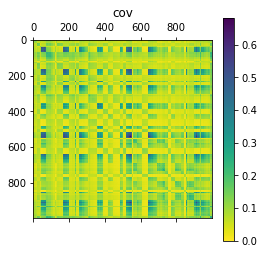

In [394]:
plt.matshow(rain_cov[a:q,a:q],cmap='viridis_r',vmin=0)
plt.colorbar()
plt.title('cov')

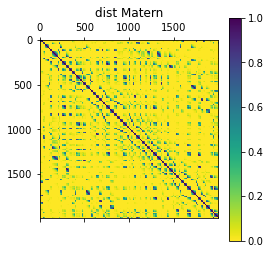

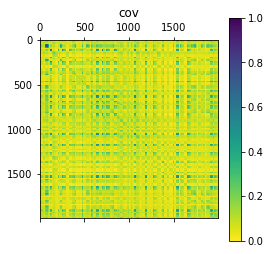

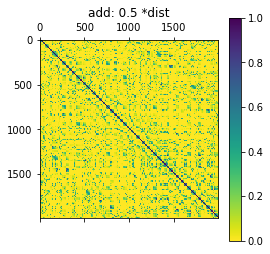

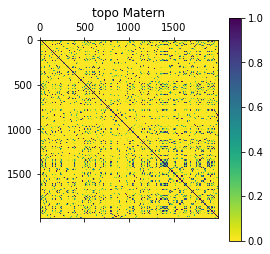

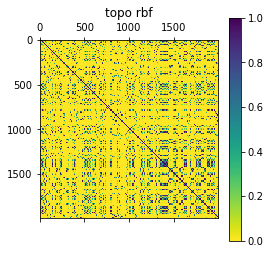

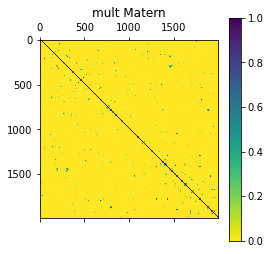

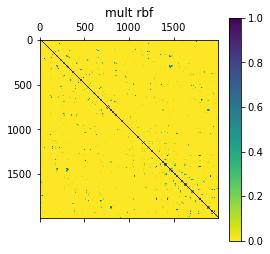

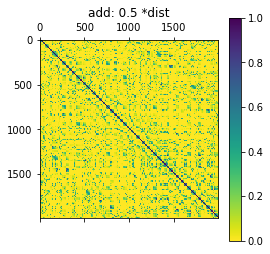

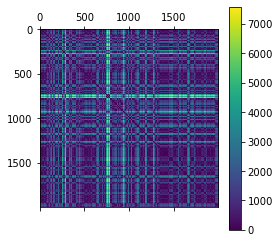

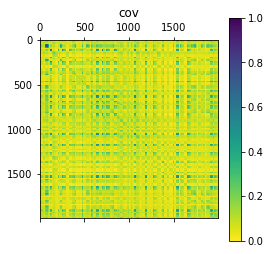

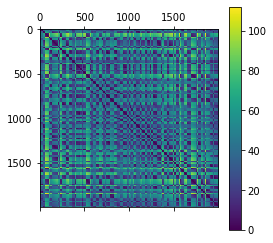

In [465]:
a=0
q=2000
theta = [208.33527405079707,3.5, 4500.926059535104,3.5] # dual anni: [208.33527405079707, 4500.926059535104]
m = 0.5


dist_cov = Matern(length_scale=theta[0],nu=theta[1]).__call__(dist_mat[a:q,a:q])
topo_cov = Matern(length_scale=theta[2],nu=theta[3]).__call__(topo_dist[a:q,a:q])
topo_cov_rbf = rbf(topo_dist[a:q,a:q],gamma=1/100000000)

plt.matshow(dist_cov,cmap='viridis_r',vmin=0,vmax=1)
plt.colorbar()
plt.title('dist Matern')

plt.matshow(rain_cov[a:q,a:q],cmap='viridis_r',vmin=0,vmax=1)
plt.colorbar()
plt.title('cov')

plt.matshow(m*dist_cov+(1-m)*topo_cov,cmap='viridis_r',vmin=0,vmax=1)
plt.colorbar()
plt.title('add: '+str(m)+' *dist')


plt.matshow(topo_cov,cmap='viridis_r',vmin=0,vmax=1)
plt.colorbar()
plt.title('topo Matern')

plt.matshow(topo_cov_rbf,cmap='viridis_r',vmin=0,vmax=1)
plt.colorbar()
plt.title('topo rbf')



plt.matshow(np.multiply(dist_cov,topo_cov),cmap='viridis_r',vmin=0,vmax=1)
plt.colorbar()
plt.title('mult Matern')

plt.matshow(np.multiply(dist_cov,topo_cov_rbf),cmap='viridis_r',vmin=0,vmax=1)
plt.colorbar()
plt.title('mult rbf')

plt.matshow(m*dist_cov+(1-m)*topo_cov,cmap='viridis_r',vmin=0,vmax=1)
plt.colorbar()
plt.title('add: '+str(m)+' *dist')


plt.matshow(topo_dist[a:q,a:q])
plt.colorbar()
plt.matshow(rain_cov[a:q,a:q],cmap='viridis_r',vmin=0,vmax=1)
plt.colorbar()
plt.title('cov')
plt.matshow(dist_mat[a:q,a:q])
plt.colorbar()


In [59]:
# Run this block to simulate. Change values at the top for day, samples, etc... Takes ~1:30m for all locations.

sim_day = 3
sim_locations = range(len(GNM_landonly[:1500]))
kernel_type = 'Matern'
theta_values = [900,3.5,13000,3.5] 
nb_samples = 10

#################################################################### Do not touch the rest ####################################################################

# Utility function
def g_Finv(day_id,loc_id,u): # take u to a value of rain according to the gamma density for that day and location
    if 1-GNM_landonly[loc_id][4][day_id]>=u: #if 1-p>u, invcdf is 0 rain
        return 0
    else: # invcdf( (u-1+p) /p)
        return scs.gamma(scale=GNM_landonly[loc_id][1][day_id]*GNM_landonly[loc_id][0][day_id],a=1/GNM_landonly[loc_id][1][day_id]).ppf((u-1+GNM_landonly[loc_id][4][day_id])/GNM_landonly[loc_id][4][day_id])

# Define censor levels pi on normal scale := di. This is done for the whole dataset, no need to touch.

censored_di = [[GNM_landonly[loc][4][day] for loc in range(len(GNM_landonly))] for day in tqdm(range(len(GNM_landonly[0][0])))] # di[day][loc]
censored_di = scs.norm.ppf(np.array(censored_di))

# Simulating Draws. Dependent on given day and locations.
simulated_us = truncgauss(dist_mat[:max(sim_locations),:max(sim_locations)]).sim(theta=theta_values,inv_ps=censored_di,draws=nb_samples,day_idx=sim_day,kernel=kernel_type,method='add',topo=topo_dist[:max(sim_locations),:max(sim_locations)],give_rvs='yes')
#simulated_rain = [[g_Finv(sim_day,loc,simulated_us[draw][loc]) for loc in range(len(simulated_us[0]))] for draw in range(len(simulated_us))]

print('Simulations done!')
























































100%|██████████| 5173/5173 [00:06<00:00, 806.50it/s]


Simulations done!


100%|██████████| 25/25 [01:03<00:00,  2.56s/it]


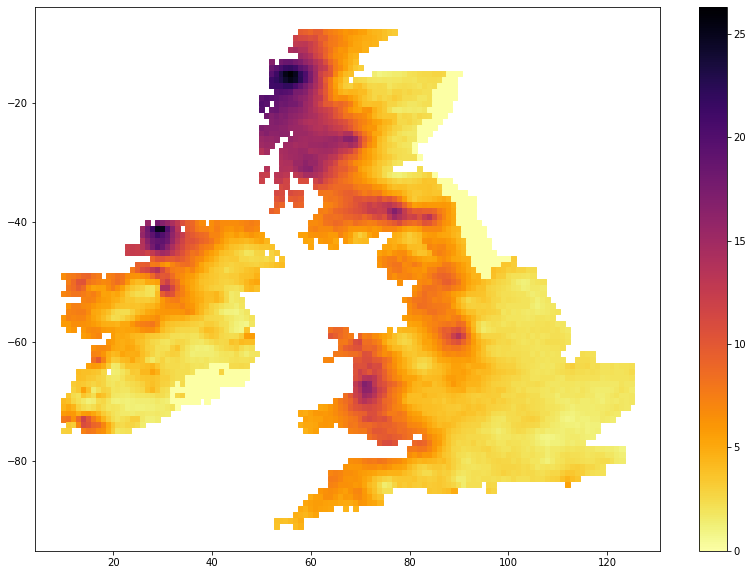

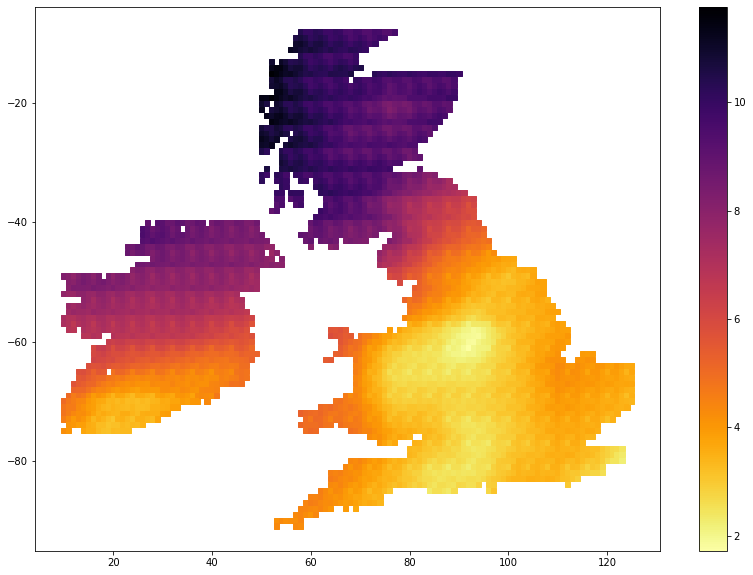

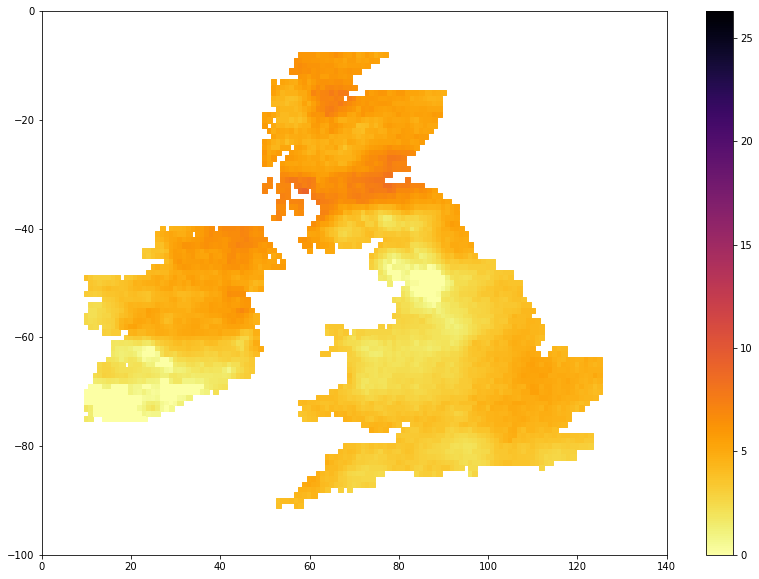

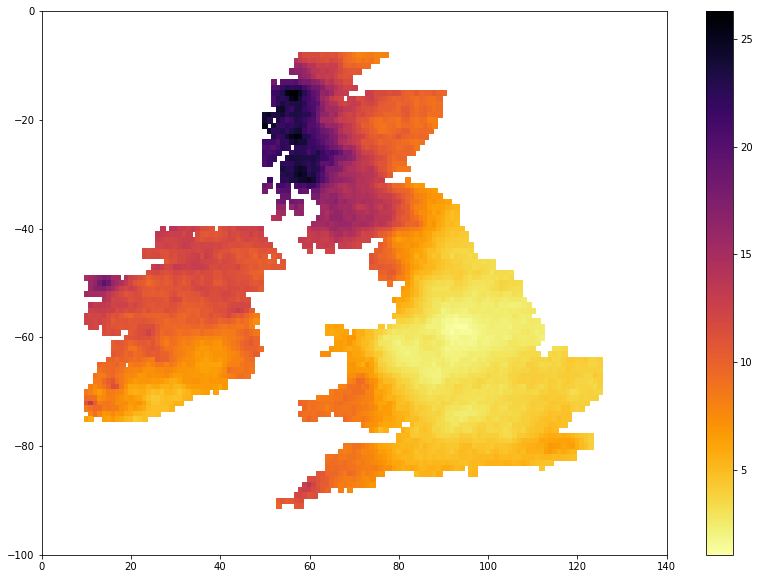

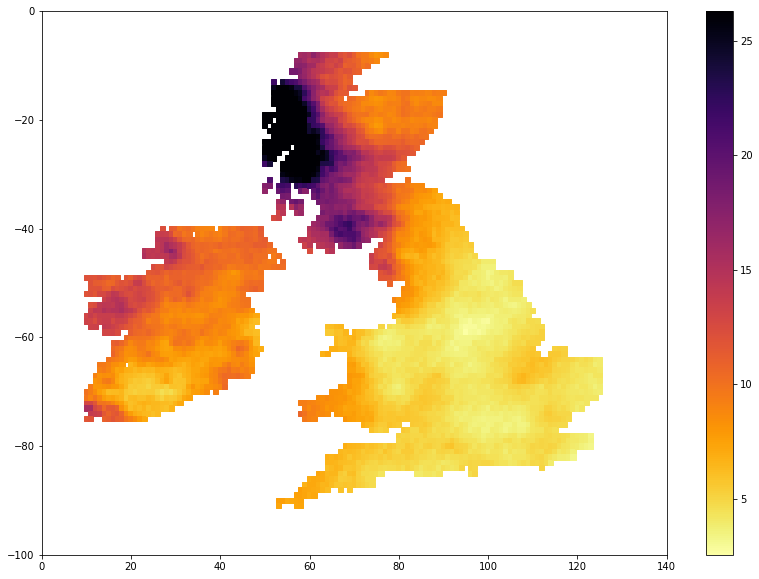

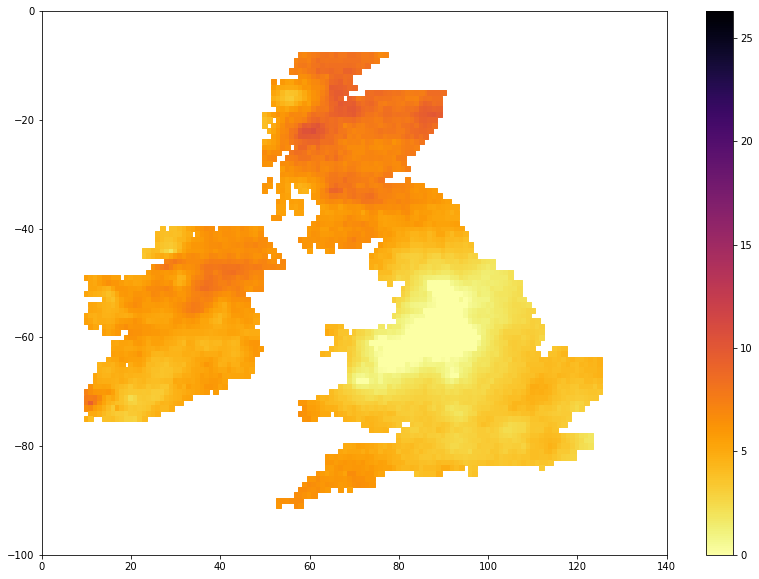

In [469]:
theta_values = [208.33370545627545,3.5, 4500.88496935951,3.5]
sim_day=306
sim_locations = range(len(GNM_landonly)+1)

simulated_us = truncgauss(dist_mat[:max(sim_locations),:max(sim_locations)]).sim(theta=theta_values,inv_ps=censored_di,draws=25,day_idx=sim_day,a=0.65,aaa=True,kernel='Matern',method='add',topo=topo_dist[:max(sim_locations),:max(sim_locations)],give_rvs='yes')
simulated_rain = [[g_Finv(sim_day,loc,scs.norm.cdf(simulated_us[draw][loc])) for loc in range(len(simulated_us[0]))] for draw in tqdm(range(len(simulated_us)))]
fig = plt.gcf() 
fig.set_size_inches(14,10)
plt.scatter([GNM_landonly[loc][5][1] for loc in range(4087)],[-GNM_landonly[loc][5][0] for loc in range(4087)],c=[GNM_landonly[k][3][sim_day] for k in range(4087)],cmap='inferno_r',s=27,marker='s')
plt.colorbar()
plt.show()

fig = plt.gcf() 
fig.set_size_inches(14,10)
plt.scatter([GNM_landonly[loc][5][1] for loc in range(4087)],[-GNM_landonly[loc][5][0] for loc in range(4087)],c=[g_Finv(sim_day,loc,0.5) for loc in range(4087)],cmap='inferno_r',s=27,marker='s')
plt.colorbar()
plt.show()

for sample in range(4):
    fig = plt.gcf() 
    fig.set_size_inches(14,10)
    plt.scatter([GNM_landonly[loc][5][1] for loc in range(len(simulated_us[0]))],[-GNM_landonly[loc][5][0] for loc in range(len(simulated_us[0]))],c=simulated_rain[sample],cmap='inferno_r',s=27,marker='s',vmax=max([GNM_landonly[k][3][sim_day] for k in range(4087)]))
    plt.colorbar()
    plt.xlim(0,140)
    plt.ylim(-100,0)
    plt.show()

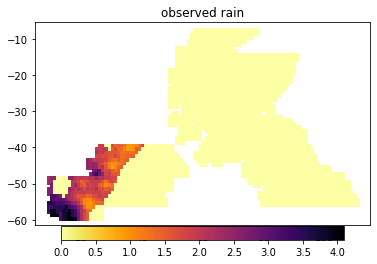

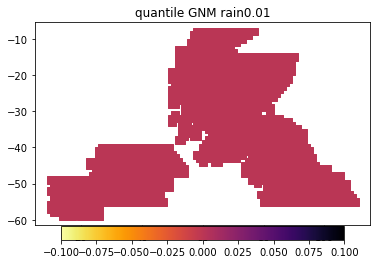

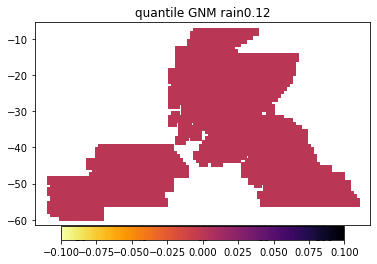

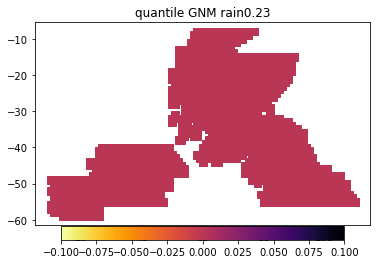

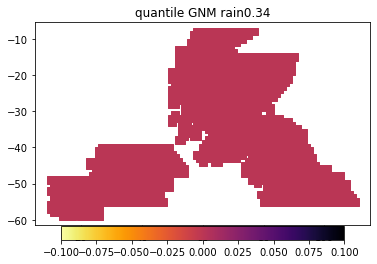

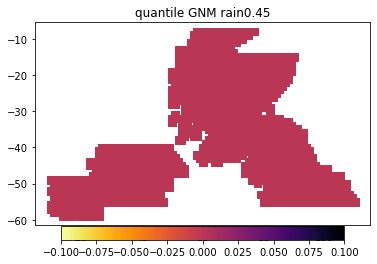

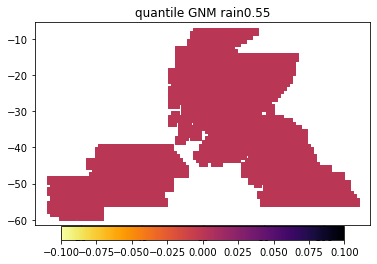

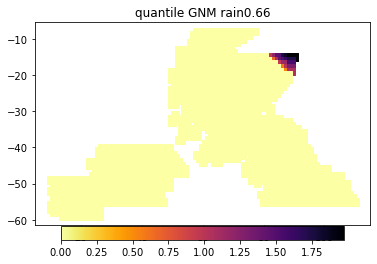

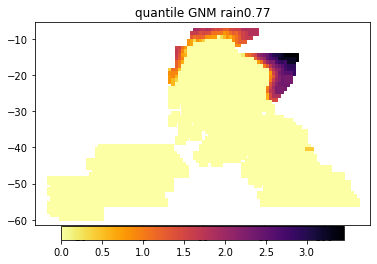

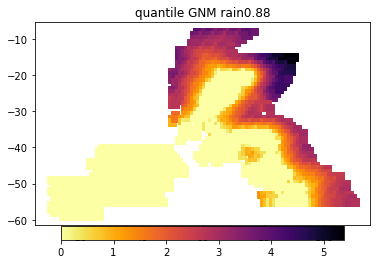

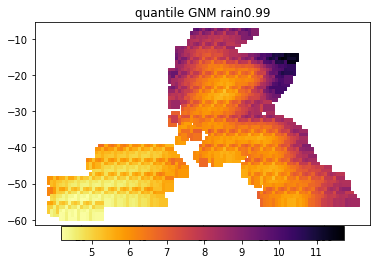

In [7]:
# Plotting quantiles
for day in [sim_day]:
    fig = plt.gcf()
    color = plt.cm.rainbow(np.linspace(0, 1, len(GNM_landonly)))
    plt.scatter([GNM_landonly[loc][5][1] for loc in sim_locations[:-1]],[-GNM_landonly[loc][5][0] for loc in sim_locations[:-1]],c=[GNM_landonly[loc][3][day] for loc in sim_locations[:-1]],cmap='inferno_r',s=60,marker='s')
    plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
    plt.title('observed rain')
    plt.show()
    for draw in range(nb_samples):
        plt.scatter([GNM_landonly[loc][5][1] for loc in sim_locations[:-1]],[-GNM_landonly[loc][5][0] for loc in sim_locations[:-1]],c=[g_Finv(day,loc,np.linspace(0.01,0.99,10)[draw]) for loc in sim_locations[:-1]],cmap='inferno_r',s=60,marker='s')
        plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
        plt.title('quantile GNM rain'+str(round(np.linspace(0.01,0.99,nb_samples)[draw],2)))
        plt.show()

### Working with elevation

In [98]:
import netCDF4 as nc
fn = 'topo_0.1_degree.nc'
ds = nc.Dataset(fn)
h = ds['Band1'][:]
h = np.flip(np.matrix(h),axis=0)
topo_dist = euclidean_distances(np.array([h[loc[5][0],loc[5][1]+2] for loc in GNM_landonly]).reshape(-1,1))

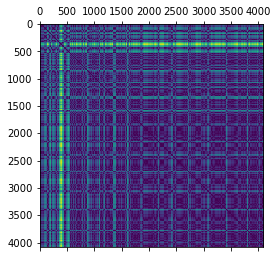

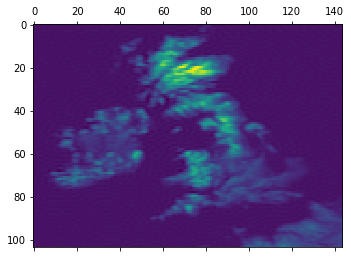

In [100]:
plt.matshow(topo_dist)
plt.show()
plt.matshow(h)